In [2]:
import gurobipy as gp
from gurobipy import GRB
import pickle
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

In [3]:
a = 50
M = 1000
T_u, T_b, T_l = 150, 120, 90
with open('../pkl_file/true_data_params.pkl', 'rb') as f:
    params = pickle.load(f)
b0_list = []
b1_list = []
T0_list = []
for param in params:
    b0, b1, T0 = param
    b0_list.append(b0)
    b1_list.append(b1)
    T0_list.append(T0)

In [4]:
hashmap = {0: (66, 0), 1: (132, 2), 2: (264, 6), 3: (132, 8), 4: (264, 12), 5: (132, 14), 6: (198, 17), 7: (66, 18), 8: (264, 22),
           9: (198, 25), 10: (66, 26), 11: (330, 31), 12: (66, 32), 13: (132, 34), 14: (66, 35), 15: (66, 36), 16: (132, 38), 17: (66, 39),
           18: (66, 40), 19: (132, 42), 20: (132, 44), 21: (264, 48), 22: (66, 49), 23: (132, 51), 24: (132, 53) 
           }

In [5]:
def solve_for_partition(partition_index, initial_speed=20):
    partition_length, profile_index = hashmap[partition_index]
    number_of_segements = partition_length * 10
    mdl = gp.Model('speed_control_with_acceleration')
    # final speed of this partition, we calculate acceleration based on speed
    v = mdl.addVar(vtype=GRB.CONTINUOUS, lb=5, ub=100, name=f'v')
    # square of speed
    v_square = mdl.addVar(vtype=GRB.CONTINUOUS, lb=25, ub=10000, name=f'v_square')
    # 1 / speed
    v_inverse = mdl.addVar(vtype=GRB.CONTINUOUS, lb=0.01, ub=0.2, name=f'v_inverse')
    # sign to calculate time, 1 for acceleration, 0 for deceleration
    delta_v_positive = mdl.addVar(vtype=GRB.BINARY, name=f'delta_v_positive')
    # acceleration distance for each partition, based on (v^2 - v_0^2)/2a
    d = mdl.addVar(vtype=GRB.CONTINUOUS, lb=0, ub=partition_length, name=f'distance')
    # Binary variable for determining whether segement inside acceleration distance
    inside_acceleration = [mdl.addVar(vtype=GRB.BINARY, name=f'inside_acceleration_{i}') for i in range(number_of_segements)]
    # speed in the end of each segment of each partition
    v_inside_partition = [mdl.addVar(vtype=GRB.CONTINUOUS, lb=5, ub=100, name=f'v_inside_partition{i}') for i in range(number_of_segements)]
    v_inside_partition_square = [mdl.addVar(vtype=GRB.CONTINUOUS, lb=25, ub=10000, name=f'v_inside_partition_square{i}') for i in range(number_of_segements)]
    v_inside_average = [mdl.addVar(vtype=GRB.CONTINUOUS, lb=0, ub=100, name=f'v_inside_avg{i}') for i in range(number_of_segements)]
    # time spent for each segment
    t = [mdl.addVar(vtype=GRB.CONTINUOUS, lb=0, ub=500, name=f't_{i}') for i in range(number_of_segements)]
    mdl.update()

    mdl.addConstr(v_inverse * v == 1)
    mdl.addConstr(v_square == v*v)
    mdl.addConstr(v >= 0.95*initial_speed)
    mdl.addConstr(v <= 1.05*initial_speed)
    # determine acceleration or deceleration
    mdl.addConstr(v - initial_speed <= M * delta_v_positive)
    mdl.addConstr(v - initial_speed >= (1 - delta_v_positive) * (-M))
    # calculate acceleration distance
    mdl.addConstr(d == delta_v_positive * (v_square - initial_speed**2) / (2*a) + (1-delta_v_positive) * (initial_speed**2 - v_square) / (2*a))

    for i in range(number_of_segements):
        mdl.addConstr(0.1 * (i+1) - d <= M * (1 - inside_acceleration[i]))
        mdl.addConstr(d - 0.1 * (i+1) <= M * inside_acceleration[i])
    for i in range(number_of_segements):
        mdl.addConstr(v_inside_partition_square[i] == v_inside_partition[i] * v_inside_partition[i])

    mdl.addConstr(v_inside_partition_square[0] == initial_speed**2 + delta_v_positive * (2*a*0.1*inside_acceleration[0]) + (1-delta_v_positive)*(-2*a*0.1*inside_acceleration[i]))
    for i in range(1, number_of_segements):
        mdl.addConstr(v_inside_partition_square[i] == v_inside_partition_square[i-1] + delta_v_positive * (2*a*0.1*inside_acceleration[i]) + (1-delta_v_positive) * (-2*a*0.1*inside_acceleration[i]))

    mdl.addConstr(v_inside_average[0] * 2 == initial_speed + v_inside_partition[0])
    for i in range(1, number_of_segements):
        mdl.addConstr(v_inside_average[i] * 2 == v_inside_partition[i-1] + v_inside_partition[i])

    for i in range(number_of_segements):
        mdl.addConstr(t[i] * v_inside_average[i] == 0.1)

    prefix_sum = [mdl.addVar(vtype=GRB.CONTINUOUS, lb=0, ub=GRB.INFINITY, name=f'prefix_sum_{i}') for i in range(number_of_segements)]
    mdl.addConstr(prefix_sum[0] == t[0])
    for i in range(1, number_of_segements):
        mdl.addConstr(prefix_sum[i] == prefix_sum[i-1] + t[i])

    t_profile = [mdl.addVar(vtype=GRB.CONTINUOUS, lb=0, ub=GRB.INFINITY, name=f't_profile_{i}') for i in range(number_of_segements)]

    for i in range(number_of_segements):
        sum_term = prefix_sum[i]
        mdl.addConstr(t_profile[i] == (53 - partition_index) * (66/20) + sum_term)
    exp_var = [mdl.addVar(name=f'exp_term_{i}') for i in range(number_of_segements)]
    mul_var = [mdl.addVar(vtype=GRB.CONTINUOUS, lb=-10, ub=0, name=f'mul_var_{i}') for i in range(number_of_segements)]
    temperature_var = [mdl.addVar(name=f'temperature{i}') for i in range(number_of_segements)]

    for i in range(number_of_segements):
        mdl.addConstr(mul_var[i] == b1_list[profile_index] * t_profile[i])
        mdl.addGenConstrExp(mul_var[i], exp_var[i])
        mdl.addConstr(temperature_var[i] == 24 - (b0_list[profile_index] / b1_list[profile_index]) + (T0_list[profile_index] - 24 + (b0_list[profile_index] / b1_list[profile_index])) * exp_var[i])
        mdl.addConstr(temperature_var[i] >= T_l)
        mdl.addConstr(temperature_var[i] <= T_u)

    objective = gp.quicksum((temperature_var[i] - T_b) * (temperature_var[i] - T_b) for i in range(number_of_segements))
    mdl.setObjective(objective, GRB.MINIMIZE)
    mdl.optimize()
    temp_diff = []
    for i in range(number_of_segements):
        temp_diff.append(temperature_var[i].X - T_b)
    return v.X, temp_diff


In [6]:
speed, temp_diff = solve_for_partition(0)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-10-07
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.0.0 24A335)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 5944 rows, 6605 columns and 11884 nonzeros
Model fingerprint: 0xe248cb23
Model has 660 quadratic objective terms
Model has 1983 quadratic constraints
Model has 660 general constraints
Variable types: 5944 continuous, 661 integer (661 binary)
Coefficient statistics:
  Matrix range     [1e-02, 1e+03]
  QMatrix range    [2e-02, 2e+01]
  QLMatrix range   [1e-02, 1e+01]
  Objective range  [2e+02, 2e+02]
  QObjective range [2e+00, 2e+00]
  Bounds range     [1e-02, 1e+04]
  RHS range        [1e-01, 1e+03]
  QRHS range       [1e-01, 4e+02]
Presolve removed 4596 rows and 3953 columns
Presolve time: 0.03s
Presolved: 5975 rows, 2652 columns, 13629 nonzeros
Presolved model has 659 quadratic objective te

In [7]:
speed_map = defaultdict(int)
temp_diff_map = defaultdict(list)
initial_speed = 20
for i in range(25):
    v, temp_diff = solve_for_partition(i, initial_speed)
    initial_speed = v
    speed_map[i] = v
    temp_diff_map[i] = temp_diff

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.0.0 24A335)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 5944 rows, 6605 columns and 11884 nonzeros
Model fingerprint: 0xe248cb23
Model has 660 quadratic objective terms
Model has 1983 quadratic constraints
Model has 660 general constraints
Variable types: 5944 continuous, 661 integer (661 binary)
Coefficient statistics:
  Matrix range     [1e-02, 1e+03]
  QMatrix range    [2e-02, 2e+01]
  QLMatrix range   [1e-02, 1e+01]
  Objective range  [2e+02, 2e+02]
  QObjective range [2e+00, 2e+00]
  Bounds range     [1e-02, 1e+04]
  RHS range        [1e-01, 1e+03]
  QRHS range       [1e-01, 4e+02]
Presolve removed 4596 rows and 3953 columns
Presolve time: 0.04s
Presolved: 5975 rows, 2652 columns, 13629 nonzeros
Presolved model has 659 quadratic objective terms
Presolved model has 1322 bilinear constraint(s)

Solving non-convex MIQCP

Variable typ

In [8]:
speed_list = list(speed_map.values())
speed_list

[20.976176963402978,
 22.024985811573128,
 22.91506054977807,
 24.060813577266973,
 25.263854256130323,
 26.52704696893684,
 27.853399317383683,
 29.24606928325287,
 30.708372747415513,
 29.172954110044735,
 27.714306404542498,
 29.100021724769626,
 27.645020638531143,
 26.262769606604586,
 24.949631126274355,
 23.702149569960635,
 22.517042091462603,
 21.391189986889472,
 20.321630487544997,
 19.305548963167745,
 18.340271515009356,
 17.423257939258885,
 16.55209504229594,
 15.72449029018114,
 14.938265775672082]

In [ ]:
# action = [speed_list[0]/20]
# for i in range(1, 25):
#     action.append(speed_list[i] / speed_list[i-1])

In [ ]:
# action

[1.048808848170149,
 1.05,
 1.0404120459290942,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 0.95,
 0.95,
 1.05,
 0.95,
 0.95,
 0.95,
 0.95,
 0.95,
 0.95,
 0.95,
 0.9499999999999998,
 0.95,
 0.9499999999999998,
 0.9499999999999998,
 0.95,
 0.95]

In [9]:
v5_speed_history = [20.6, 21.630000000000003, 22.711500000000004, 23.847075000000007, 25.03942875000001, 26.29140018750001, 27.60597019687501, 28.98626870671876, 30.4355821420547, 31.34864960631634, 32.28910909450583, 30.997544730725597, 29.75764294149657, 28.567337223836706, 27.13897036264487, 26.053411548139074, 24.75074097073212, 24.5032335610248, 24.258201225414552, 25.228529274431136, 25.228529274431136, 24.723958688942513, 25.46567744961079, 25.97499099860301, 26.7542407285611]
v5_temp_diff = [-9.32380600976275, -5.8825694846671315, -6.5570005930719875, -8.228519253651518, -7.158326622778624, -11.523316266999426, -5.47552213967816, -4.706654705009872, -3.248133368582439, -0.582819898927476, 3.0267813067227127, -1.8251338312530567, -0.3644557157728776, -1.1855422777567548, -3.691127056469413, -1.8450395711497525, -1.8237381234580943, -4.927574548555246, -0.8079224494151886, -0.5803731744809203, -0.3448437296956886, 2.580665674364849, 4.9241833634181456, 0.16690536535277625, 2.422914868003185]

In [10]:
T_env = 24
def get_temperature_from_params(t, b0, b1, T0):
    return T_env - (b0/b1) + (T0 - T_env + (b0/b1))*np.exp(b1*t)

In [11]:
fixed_diff = []
t_acc = 0
for i in range(25):
    length, index = hashmap[i]
    t = 54*(66/20)
    fixed_diff.append(get_temperature_from_params(t, b0_list[index], b1_list[index], T0_list[index]) - T_b)

In [12]:
import numpy as np
diff = []
for i in range(25):
    diff.append(np.mean(temp_diff_map[i]))

In [13]:
import matplotlib.pyplot as plt

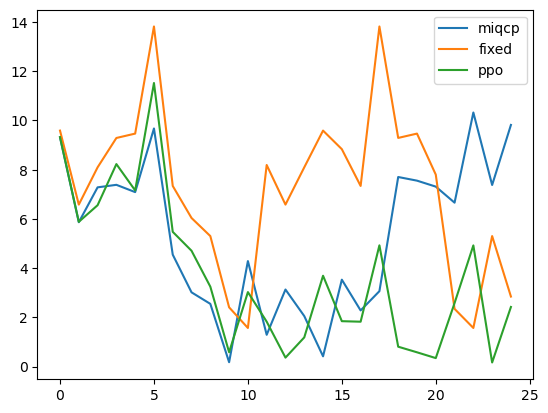

In [14]:
plt.plot(np.abs(diff), label='miqcp')
plt.plot(np.abs(fixed_diff), label='fixed')
plt.plot(np.abs(v5_temp_diff), label='ppo')
plt.legend()
plt.show()

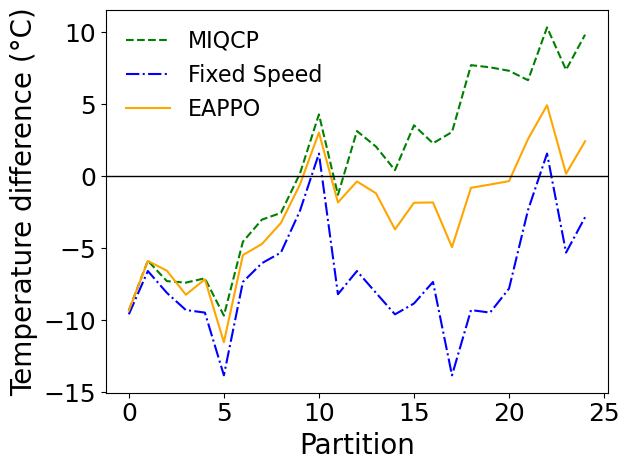

In [16]:
plt.plot(diff, label='MIQCP', linestyle='dashed', color='green')
plt.plot(fixed_diff, label='Fixed Speed', linestyle='dashdot', color='blue')
plt.plot(v5_temp_diff, label='EAPPO', linestyle='solid', color='orange')
plt.axhline(y=0, color='black', linestyle='-', linewidth=1)
plt.legend(frameon=False, fontsize=16)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel("Partition", fontsize=20)
plt.ylabel("Temperature difference (°C)", fontsize=20)
plt.tight_layout()
plt.savefig('../paper_plot/acceleration_performance.png')
plt.show()

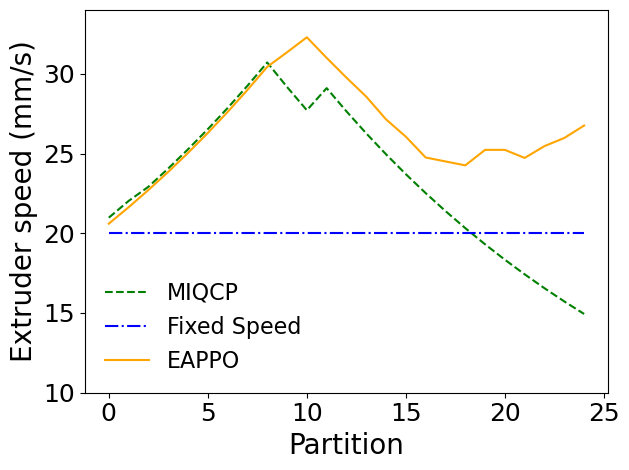

In [18]:
plt.plot(speed_list, label='MIQCP', linestyle='dashed', color='green')
plt.plot([20]*25, label='Fixed Speed', linestyle='dashdot', color='blue')
plt.plot(v5_speed_history, label='EAPPO', linestyle='solid', color='orange')
plt.legend(frameon=False, fontsize=16)
plt.ylim(10,34)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel("Partition", fontsize=20)
plt.ylabel("Extruder speed (mm/s)", fontsize=20)
plt.tight_layout()
plt.savefig('../paper_plot/accelearation_policy.png')
plt.show()

In [19]:
diff_abs = np.abs(diff)
fixed_diff_abs = np.abs(fixed_diff)
v5_temp_diff_abs = np.abs(v5_temp_diff)

In [20]:
ppo_time = 135.46284832424143
miqcp = 155.36550420447824
fixed = 178.20000

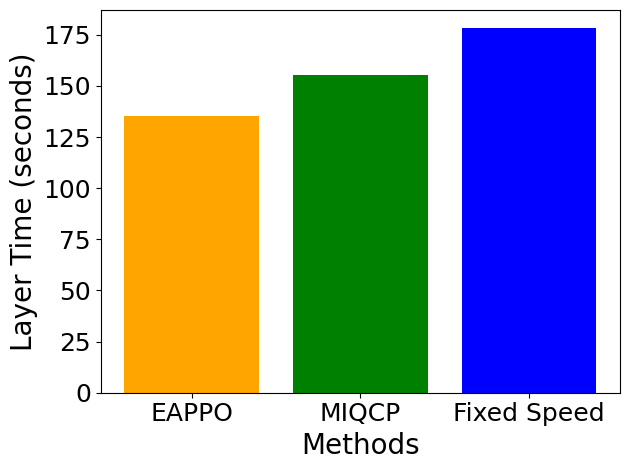

In [28]:
times = [135.4628, 155.3655, 178.2]
labels = ['EAPPO', 'MIQCP', 'Fixed Speed']
colors = ['orange', 'green', 'blue'] 
plt.bar(labels, times, color=colors)
plt.xlabel("Methods", fontsize=20)
plt.ylabel("Layer Time (seconds)", fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.savefig('../paper_plot/acceleration_layer_time.png')
plt.show()

In [31]:
diff_obj = sum([diff_abs[i]**2 for i in range(25)])+miqcp
ppo_obj = sum([v5_temp_diff_abs[i]**2 for i in range(25)])+ppo_time
fixed_obj = sum([fixed_diff_abs[i]**2 for i in range(25)])+fixed

In [32]:
print(diff_obj)
print(ppo_obj)
print(fixed_obj)

1097.437705286852
711.3368034800545
1744.5818122111357


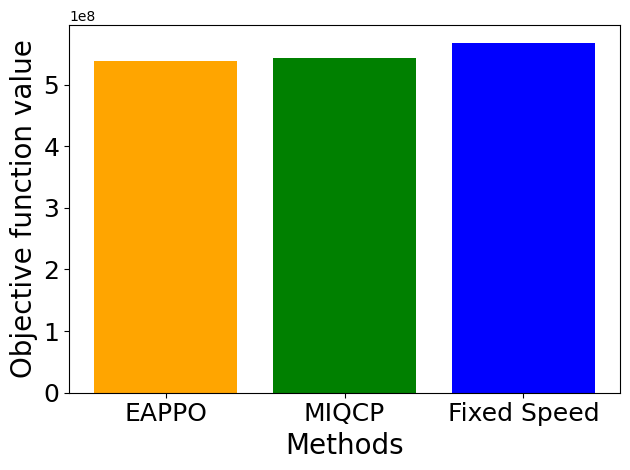

In [36]:
times = [538825189.87, 542627106.84, 568148142.38]
labels = ['EAPPO', 'MIQCP', 'Fixed Speed']
colors = ['orange', 'green', 'blue'] 
plt.bar(labels, times, color=colors)
plt.xlabel("Methods", fontsize=20)
plt.ylabel("Objective function value", fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.savefig('../paper_plot/acceleration_obj.png')
plt.show()